# Network analysis in Python

**Credit**
[Vuokko Heikinheimo, Henrikki Tenkanen](https://automating-gis-processes.github.io/)  
Department of Geosciences & Geography, University of Helsinki  

Finding a shortest path using a specific street network is a common GIS problem that has many practical
applications. For example navigators are one of those "every-day" applications where **routing** using specific algorithms is used to find the optimal route between two (or multiple) points.

It is also possible to perform network analysis such as tranposrtation routing in Python.
[Networkx](https://networkx.github.io/documentation/stable/) is a Python module that provides tools for analyzing networks in various different ways. It also contains algorithms
such as [Dijkstra's algorithm](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra.html#networkx.algorithms.shortest_paths.weighted.single_source_dijkstra) or
[A*](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.astar.astar_path.html#networkx.algorithms.shortest_paths.astar.astar_path) algoritm that are commonly used to find shortest paths along transportation network.

To be able to conduct network analysis, it is, of course, necessary to have a network that is used for the analyses. [OSMnx](https://github.com/gboeing/osmnx) package that we just explored in previous tutorial, makes it really easy to retrieve routable networks from OpenStreetMap with different transport modes (walking, cycling and driving). OSMnx also combines some functionalities from `networkx` module to make it straightforward to conduct routing along OpenStreetMap data.

Next we will test the routing functionalities of OSMnx by finding a shortest path between two points based on drivable roads. With tiny modifications, it is also possible to repeat the analysis for the walkable street network.

## Get the network

Let's again start by importing the required modules

In [2]:
import os

import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from pyproj import CRS
from shapely.geometry import LineString, Point

When fetching netowrk data from OpenStreetMap using OSMnx, it is possible to define the type of street network using the `network_type` parameter (options: `drive`, `walk` and `bike`).
Let's download the OSM data from Kamppi but this only the drivable network. Alternatively, you can also fetch the walkable network (this will take a bit longer time). 

In [3]:
# Define place name
place_name = "Burnaby, BC, Canada"

# Get the drivable (or walkable) network
graph = ox.graph_from_place(place_name, network_type='drive')

Plot the graph:

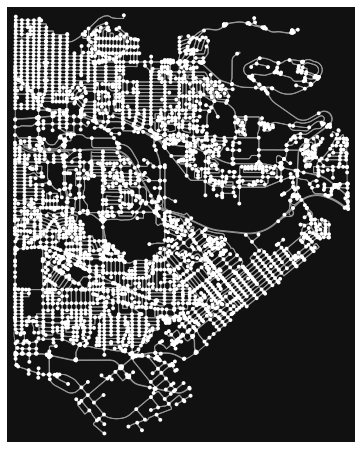

In [4]:
fig, ax = ox.plot_graph(graph)

Now we have retrieved only such streets where it is possible to drive with a car. Let's confirm
this by taking a look at the attributes of the street network. Easiest way to do this is to convert the
graph (nodes and edges) into GeoDataFrames.

Converting graph into a GeoDataFrame can be done with function `graph_to_gdfs()` that we already used in previous tutorial. With parameters `nodes` and `edges`, it is possible to control whether to retrieve both nodes and edges from the graph. 

In [5]:
# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [6]:
# Check columns
edges.columns

Index(['osmid', 'oneway', 'lanes', 'highway', 'length', 'geometry', 'ref',
       'name', 'maxspeed', 'access', 'bridge', 'junction', 'tunnel', 'width'],
      dtype='object')

In [7]:
# Check crs
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Note that the CRS of the GeoDataFrame is WGS84 (epsg: 4326).

In [8]:
edges.head()

osmid  \
u        v          key                                                      
25251525 431379474  0                                             35482602   
         345182627  0                                            743739762   
25251543 8309603131 0                               [336156279, 221379391]   
         346727415  0    [894050052, 221379388, 51316791, 606620727, 25...   
25260283 25325913   0                                              8136458   

                         oneway   lanes         highway    length  \
u        v          key                                             
25251525 431379474  0      True       1   motorway_link   536.305   
         345182627  0      True       4        motorway   504.235   
25251543 8309603131 0      True     NaN   motorway_link   610.852   
         346727415  0      True  [5, 4]        motorway  1386.577   
25260283 25325913   0      True       2  secondary_link    75.464   

                                                                  geometry  \
u        v          key                                                      
25251525 431379474  0    LINESTRING (-122.96269 49.24184, -122.96330 49...   
         345182627  0    LINESTRING (-122.96269 49.24184, -122.96340 49...   
25251543 8309603131 0    LINESTRING (-122.89367 49.24306, -122.89427 49...   
         346727415  0    LINESTRING (-122.89367 49.24306, -122.89450 49...   
25260283 25325913   0    LINESTRING (-122.91182 49.24580, -122.91216 49...   

                         ref                  name maxspeed access bridge  \
u        v          key                                                     
25251525 431379474  0    NaN                   NaN      NaN    NaN    NaN   
         345182627  0      1  Trans-Canada Highway       90    NaN    NaN   
25251543 8309603131 0    NaN                   NaN      NaN     no    NaN   
         346727415  0      1  Trans-Canada Highway       90    NaN    yes   
25260283 25325913   0    NaN                   NaN       50    NaN    NaN   

                        junction tunnel width  
u        v          key                        
25251525 431379474  0        NaN    NaN   NaN  
         345182627  0        NaN    NaN   NaN  
25251543 8309603131 0        NaN    NaN   NaN  
         346727415  0        NaN    NaN   NaN  
25260283 25325913   0        NaN    NaN   NaN

We have quite many columns in our GeoDataFrame. Most of the columns are fairly self-explanatory but the following table describes all of them.
Most of the attributes come directly from the OpenStreetMap, however, columns `u` and `v` are Networkx specific ids. You can click on the links to get more information about each attribute:


| Column                                                     | Description                 | Data type         |
|------------------------------------------------------------|-----------------------------|-------------------|
| [bridge](http://wiki.openstreetmap.org/wiki/Key:bridge)    | Bridge feature              | boolean           |
| geometry                                                   | Geometry of the feature     | Shapely.geometry  |
| [highway](http://wiki.openstreetmap.org/wiki/Key:highway)  | Tag for roads (road type)   | str / list        |
| [lanes](http://wiki.openstreetmap.org/wiki/Key:lanes)      | Number of lanes             | int (or nan)      |
| [lenght](http://wiki.openstreetmap.org/wiki/Key:length)    | Length of feature (meters)  | float             |
| [maxspeed](http://wiki.openstreetmap.org/wiki/Key:maxspeed)| maximum legal speed limit   | int /list         |
| [name](http://wiki.openstreetmap.org/wiki/Key:name)        | Name of the (street) element| str (or nan)      |
| [oneway](http://wiki.openstreetmap.org/wiki/Key:oneway)    | One way road                | boolean           |
| [osmid](http://wiki.openstreetmap.org/wiki/Node)           | Unique ids for the element  | list              |
| [u](http://ow.ly/bV8n30h7Ufm)                              | The first node of edge      | int               |
| [v](http://ow.ly/bV8n30h7Ufm)                              | The last node of edge       | int               |


Let's take a look what kind of features we have in the `highway` column:

In [11]:
for hwy in edges.highway.unique():
    print(hwy)

motorway_link
motorway
secondary_link
secondary
tertiary
residential
primary
unclassified
primary_link
tertiary_link
living_street


Now we can confirm that as a result our street network indeed only contains such streets where it is allowed to drive with a car as there are no e.g. cycleways or footways included in the data.

As the data is in WGS84 format, we might want to reproject our data into a metric system before proceeding to the shortest path analysis.
We can re-project the graph from latitudes and longitudes to an appropriate UTM zone using the [project_graph()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph) function from OSMnx. 

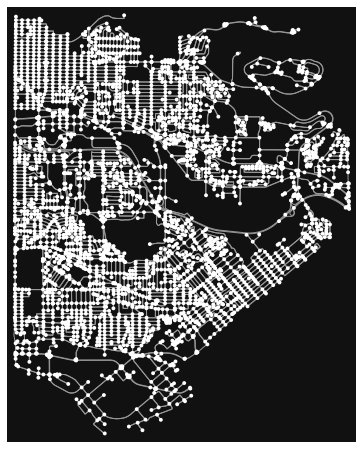

In [13]:
# Project the data
graph_proj = ox.project_graph(graph)
fig, ax = ox.plot_graph(graph_proj)

In [14]:
# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [15]:
# Check crs
edges_proj.crs

<Projected CRS: +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
# First rows
edges_proj.head()

osmid  oneway lanes        highway   length  \
u         v         key                                                    
25251525  431379474 0     35482602    True     1  motorway_link  536.305   
          345182627 0    743739762    True     4       motorway  504.235   
431379474 345181910 0     26427797    True   NaN  motorway_link   48.783   
          345181580 0     35483428    True     1  motorway_link   75.858   
345182627 345566392 0    743739762    True     4       motorway  909.784   

                                                                  geometry  \
u         v         key                                                      
25251525  431379474 0    LINESTRING (502715.456 5454341.200, 502671.488...   
          345182627 0    LINESTRING (502715.456 5454341.200, 502664.118...   
431379474 345181910 0    LINESTRING (502449.448 5454727.969, 502430.079...   
          345181580 0    LINESTRING (502449.448 5454727.969, 502436.461...   
345182627 345566392 0    LINESTRING (502308.090 5454624.164, 502292.512...   

                         ref                  name maxspeed access bridge  \
u         v         key                                                     
25251525  431379474 0    NaN                   NaN      NaN    NaN    NaN   
          345182627 0      1  Trans-Canada Highway       90    NaN    NaN   
431379474 345181910 0    NaN                   NaN      NaN    NaN    NaN   
          345181580 0    NaN                   NaN      NaN    NaN    NaN   
345182627 345566392 0      1  Trans-Canada Highway       90    NaN    NaN   

                        junction tunnel width  
u         v         key                        
25251525  431379474 0        NaN    NaN   NaN  
          345182627 0        NaN    NaN   NaN  
431379474 345181910 0        NaN    NaN   NaN  
          345181580 0        NaN    NaN   NaN  
345182627 345566392 0        NaN    NaN   NaN

As we can see from the CRS the data is now in [UTM projection](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) using zone 35 which is the one used for Finland, and indeed the orientation of the map and the geometry values also confirm this.


Furthermore, we can check the epsg code of this projection using pyproj CRS:

In [17]:
CRS(edges_proj.crs).to_epsg()

32610

Indeed, the projection is now [WGS 84 / UTM zone 35N, EPSG:32635](https://epsg.io/32635).

## Analyzing the network properties

Now as we have seen some of the basic functionalities of OSMnx such as downloading the data and converting data from graph to GeoDataFrame, we can take a look some of the analytical features of omsnx. Osmnx includes many useful functionalities to extract information about the network.

To calculate some of the basic street network measures we can use [basic_stats()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.basic_stats) function in OSMnx:

In [18]:
# Calculate network statistics
stats = ox.basic_stats(graph_proj, circuity_dist='euclidean')
stats

{'n': 3698,
 'm': 9352,
 'k_avg': 5.057869118442401,
 'intersection_count': 3005,
 'streets_per_node_avg': 2.8848025959978365,
 'streets_per_node_counts': {0: 0,
  1: 693,
  2: 17,
  3: 2030,
  4: 941,
  5: 15,
  6: 2},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.18739859383450513,
  2: 0.004597079502433748,
  3: 0.5489453758788534,
  4: 0.25446187128177394,
  5: 0.004056246619794483,
  6: 0.0005408328826392645},
 'edge_length_total': 1396610.3090000027,
 'edge_length_avg': 149.33814253635614,
 'street_length_total': 785906.2779999982,
 'street_length_avg': 149.01522146378426,
 'street_segments_count': 5274,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.0454891927304302,
 'self_loop_proportion': 0.0024593669803250643,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

To be able to extract the more advanced statistics (and some of the missing ones above) from the street network, it is required to have information about the coverage area of the network. Let's calculate the area of the [convex hull](https://en.wikipedia.org/wiki/Convex_hull) of the street network and see what we can get.



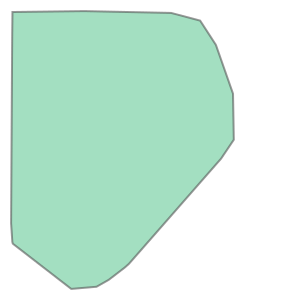

In [19]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull

# Show output
convex_hull

Now we can use the Convex Hull above to calculate [extended statistics for the network](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.extended_stats). As some of the metrics are produced separately for each node, they produce a lot of output. Here, we combine the basic and extended statistics into one pandas Series to keep things in more compact form.

In [21]:
# Calculate the area
area = convex_hull.area

# Calculate statistics with density information
stats = ox.basic_stats(graph_proj, area=area)
extended_stats = ox.extended_stats(graph_proj, ecc=True, cc=True)

# Add extened statistics to the basic statistics
for key, value in extended_stats.items():
    stats[key] = value

    
# Convert the dictionary to a Pandas series for a nicer output
pd.Series(stats)

n                                                                                   3698
m                                                                                   9352
k_avg                                                                           5.057869
intersection_count                                                                  3005
streets_per_node_avg                                                            2.884803
streets_per_node_counts                {0: 0, 1: 693, 2: 17, 3: 2030, 4: 941, 5: 15, ...
streets_per_node_proportion            {0: 0.0, 1: 0.18739859383450513, 2: 0.00459707...
edge_length_total                                                            1396610.309
edge_length_avg                                                               149.338143
street_length_total                                                           785906.278
street_length_avg                                                             149.015221
street_segments_count

As we can see, now we have a **LOT** of information about our street network that can be used to understand its structure. We can for example see that the average node density in our network is `149 nodes/km` and that the total edge length of our network is almost 20 kilometers.

Furthermore, we can see that the [degree centrality](https://en.wikipedia.org/wiki/Centrality) of our network is on average `0.0326515`. Degree is a simple centrality measure that counts how many neighbors a node has (here a fraction of nodes it is connected to). Another interesting measure is the [PageRank](https://en.wikipedia.org/wiki/PageRank) that measures the importance of specific node in the graph. Here we can see that the most important node in our graph seem to a node with osmid `25416262`. PageRank was the algorithm that Google first developed (Larry Page & Sergei Brin) to order the search engine results and became famous for.

You can read the [Wikipedia article about different centrality measures](https://en.wikipedia.org/wiki/Centrality) if you are interested what the other centrality measures mean.

## Shortest path analysis

Let's now calculate the shortest path between two points using the [shortest path function in Networkx](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#shortest-path). First we need to specify the source and target locations for our route. Let’s use the centroid of our network as the source location and the furthest point in East in our network as the target location.

Let’s first determine the centroid of our network. We can take advantage of the same Convex Hull that we used previously to determine the centroid of our data.

In [22]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull

# Centroid
centroid = convex_hull.centroid

# Show
print(centroid)

POINT (502474.9995571988 5454706.434943628)


As we can see, now we have a centroid of our network determined. We will use this later as an origin point in our routing operation.

Let’s now find the easternmost node in our street network. We can do this based on the x coordinates of the nodes:

In [23]:
nodes_proj.head()

,y,x,ref,highway,street_count,lon,lat,geometry
osmid,,,,,,,,
25251525,5.454341e+06,502715.456003,33,motorway_junction,3,-122.962694,49.241840,POINT (502715.456 5454341.200)
431379474,5.454728e+06,502449.448464,NaN,NaN,3,-122.966346,49.245320,POINT (502449.448 5454727.969)
345182627,5.454624e+06,502308.089868,NaN,NaN,3,-122.968288,49.244387,POINT (502308.090 5454624.164)
25251543,5.454482e+06,507739.162306,38,motorway_junction,3,-122.893672,49.243060,POINT (507739.162 5454481.575)
8309603131,5.454798e+06,507248.509988,NaN,NaN,3,-122.900408,49.245910,POINT (507248.510 5454797.764)


Let’s find out which node has the largest x-coordinate value. First, let’s ensure that the values are floats:

In [24]:
# Get the x coordinates of the nodes
nodes_proj['x'] = nodes_proj['x'].astype(float)

In [26]:
# Retrieve the maximum x value (i.e. the most eastern)
maxx = nodes_proj['x'].max()
print(maxx)

507815.3763440686


Let’s retrieve the target Point having the largest x-coordinate. We can do this by using the `.loc` function of Pandas that we have used already many times in earlier tutorials.

In [27]:
# Retrieve the node that is the most eastern one and get the Shapely Point geometry out of it
target = nodes_proj.loc[nodes_proj['x']==maxx, 'geometry'].values[0]
print(target)

POINT (507815.3763440686 5454430.488610559)


Now we can see that as a result we have a Shapely Point that we can use as a target point in our routing.

Let’s now find the nearest graph nodes (and their node IDs) to these points using OSMnx [get_nearest_node](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.utils.get_nearest_node). According to the documentation of this function, we need to parse Point coordinates as coordinate-tuples in this order: `latitude`, `longitude`(or `y`, `x`). As our data is now projected to UTM projection, we need to specify with `method` parameter that the function uses `'euclidean'` distances to calculate the distance from the point to the closest node (with decimal derees, use `'haversine'`, which determines the great-circle distances). The method parameter is important if you want to know the actual distance between the Point and the closest node which you can retrieve by specifying parameter `return_dist=True`.


In [28]:
# Get origin x and y coordinates
orig_xy = (centroid.y, centroid.x)

# Get target x and y coordinates
target_xy = (target.y, target.x)

In [29]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node = ox.get_nearest_node(graph_proj, orig_xy, method='euclidean')
orig_node

431379474

In [30]:
# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node = ox.get_nearest_node(graph_proj, target_xy, method='euclidean')
target_node

354629064

Now we have the IDs for the closest nodes that were found from the graph to the origin and target points that we specified.

Let’s retrieve the node information from the `nodes_proj` GeoDataFrame by passing the ids to the `loc` indexer

In [31]:
# Retrieve the rows from the nodes GeoDataFrame
o_closest = nodes_proj.loc[orig_node]
t_closest = nodes_proj.loc[target_node]

Let’s also create a GeoDataFrame that contains these points

In [32]:
# Create a GeoDataFrame from the origin and target points
od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes_proj.crs)
od_nodes.head()

,y,x,ref,highway,street_count,lon,lat,geometry
431379474,5.454728e+06,502449.448464,NaN,NaN,3,-122.966346,49.245320,POINT (502449.448 5454727.969)
354629064,5.454430e+06,507815.376344,NaN,traffic_signals,3,-122.892626,49.242599,POINT (507815.376 5454430.489)


Okay, as a result we got now the closest node IDs of our origin and target locations. As you can see, the `index` in this GeoDataFrame corresponds to the IDs that we found with `get_nearest_node()` function.

Now we are ready to do the routing and find the shortest path between the origin and target locations by using the `shortest_path()` function of networkx. With `weight` -parameter we can specify that `'length'` attribute should be used as the cost impedance in the routing. If specifying the weight parameter, NetworkX will use by default Dijkstra’s algorithm to find the optimal route. We need to specify the graph that is used for routing, and the origin `ID` (source) and the target `ID` in between the shortest path will be calculated:

In [34]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

# Show what we have
print(route)

[431379474, 345181910, 4634567245, 4634472684, 431373327, 416103938, 257846557, 257846582, 2908450388, 3840238944, 25260287, 3840238945, 4294859409, 4294859408, 332444193, 3830196217, 332457448, 4803799001, 3830196216, 957808049, 416107733, 4646744862, 4646744856, 3564793791, 354629064]


As a result we get a list of all the nodes that are along the shortest path.

We could extract the locations of those nodes from the `nodes_proj` GeoDataFrame and create a LineString presentation of the points, but luckily, OSMnx can do that for us and we can plot shortest path by using `plot_graph_route()` function:

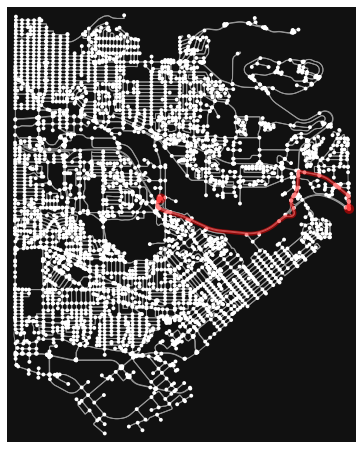

In [35]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(graph_proj, route)

Nice! Now we have the shortest path between our origin and target locations. Being able to analyze shortest paths between locations can be valuable information for many applications. Here, we only analyzed the shortest paths based on distance but quite often it is more useful to find the optimal routes between locations based on the travelled time. Here, for example we could calculate the time that it takes to cross each road segment by dividing the length of the road segment with the speed limit and calculate the optimal routes by taking into account the speed limits as well that might alter the result especially on longer trips than here.